In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import numpy as np
import pandas as pd
import msgpack
import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import midi_manipulation

%matplotlib inline

In [7]:
def get_songs(path):
    files = glob.glob('{}/*.mid*'.format(path))
    songs = []
    for f in tqdm(files):
        try:
            song = np.array(midi_manipulation.midiToNoteStateMatrix(f))
            if np.array(song).shape[0] > 50:
                songs.append(song)
        except Exception as e:
            raise e           
    return songs

In [9]:
songs = get_songs('.') #These songs have already been converted from midi to msgpack
print "{} songs processed".format(len(songs))

100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

2 songs processed


In [10]:
lowest_note = midi_manipulation.lowerBound #the index of the lowest note on the piano roll
highest_note = midi_manipulation.upperBound #the index of the highest note on the piano roll
note_range = highest_note-lowest_note #the note range

num_timesteps  = 32 #8 #This is the number of timesteps that we will create at a time
n_visible      = 2*note_range #This is the size of the visible layer. 
n_hidden       = 18 #50 #This is the size of the hidden layer
n_output = n_visible
print(n_visible)
num_epochs = 20000 #The number of training epochs that we are going to run. For each epoch we go through the entire data set.
#lr         = tf.constant(0.005, tf.float32) #The learning rate of our model

156


In [11]:
# reset_graph()
### Model Construction
num_layers = 1 #1
cell = tf.contrib.rnn.BasicRNNCell(n_hidden) # cell = tf.nn.rnn_cell.BasicLSTMCell(hidden_dim)
if num_layers > 1:
    cell = tf.contrib.rnn.MultiRNNCell([cell] * num_layers) # cell = tf.nn.rnn_cell.MultiRNNCell([cell] * num_layers) # 
#cell = tf.nn.rnn_cell.DropoutWrapper(cell,output_keep_prob=drop_out)  #optional
cell = tf.contrib.rnn.OutputProjectionWrapper(cell,n_output)

#create placeholders for X and y
X = tf.placeholder(tf.float32, shape=[None, num_timesteps, n_visible])
y = tf.placeholder(tf.float32, shape=[None, num_timesteps, n_output])
#initial_state = cell.zero_state(batch_size, tf.float32)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype = tf.float32)

In [12]:
alpha = 0.01 #01 #0.1
loss = tf.reduce_mean(tf.square(outputs - y))
#reconstruction_loss = tf.reduce_mean(tf.reduce_sum((outputs - X)*(outputs - X),1))

optimizer = tf.train.AdamOptimizer(alpha)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

Iter: 0
Loss: 0.01767
Composition of (156, 156) notes has been completed


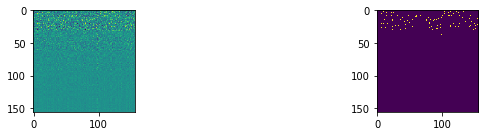

Iter: 1000
Loss: 0.003603
Composition of (156, 156) notes has been completed


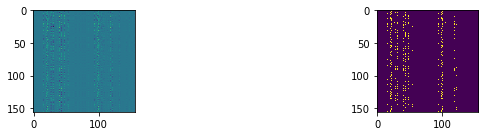

Iter: 2000
Loss: 0.005079
Composition of (156, 156) notes has been completed


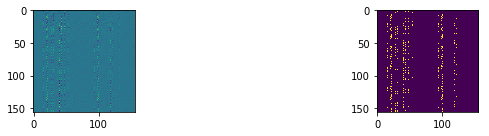

Iter: 3000
Loss: 0.003736
Composition of (156, 156) notes has been completed


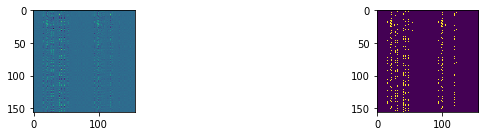

Iter: 4000
Loss: 0.004952
Composition of (156, 156) notes has been completed


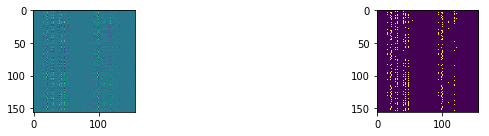

Iter: 5000
Loss: 0.003745
Composition of (156, 156) notes has been completed


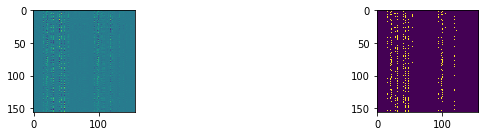

Iter: 6000
Loss: 0.004766
Composition of (156, 156) notes has been completed


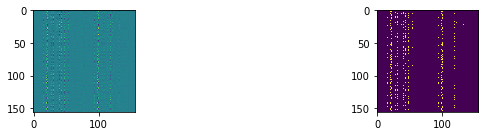

Iter: 7000
Loss: 0.003333
Composition of (156, 156) notes has been completed


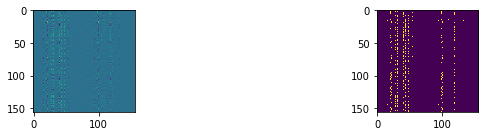

Iter: 8000
Loss: 0.005423
Composition of (156, 156) notes has been completed


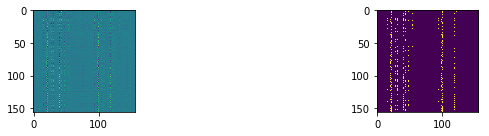

Iter: 9000
Loss: 0.003331
Composition of (156, 156) notes has been completed


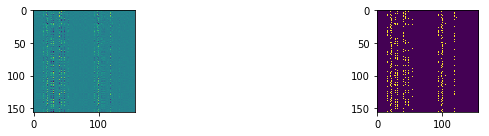

Iter: 10000
Loss: 0.006192
Composition of (156, 156) notes has been completed


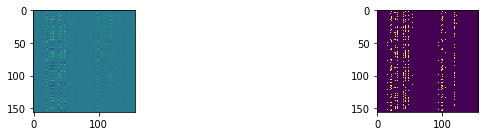

Iter: 11000
Loss: 0.003242
Composition of (156, 156) notes has been completed


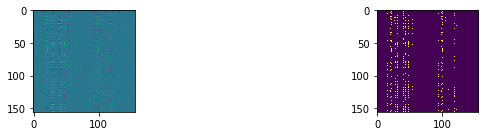

Iter: 12000
Loss: 0.004768
Composition of (156, 156) notes has been completed


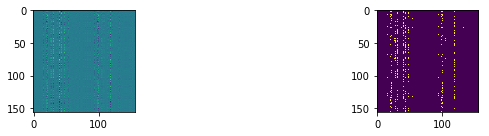

Iter: 13000
Loss: 0.003116
Composition of (156, 156) notes has been completed


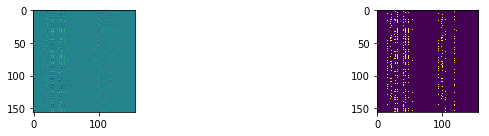

Iter: 14000
Loss: 0.005148
Composition of (156, 156) notes has been completed


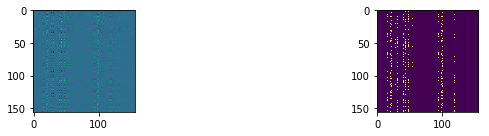

Iter: 15000
Loss: 0.002928
Composition of (156, 156) notes has been completed


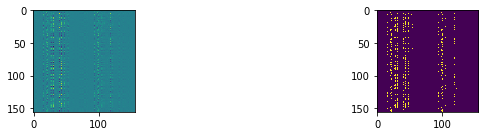

Iter: 16000
Loss: 0.004886
Composition of (156, 156) notes has been completed


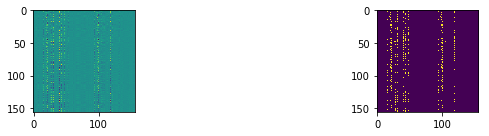

Iter: 17000
Loss: 0.003345
Composition of (156, 156) notes has been completed


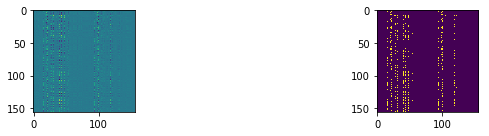

Iter: 18000
Loss: 0.004874
Composition of (156, 156) notes has been completed


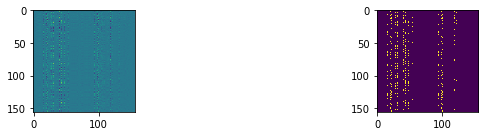

Iter: 19000
Loss: 0.003727
Composition of (156, 156) notes has been completed


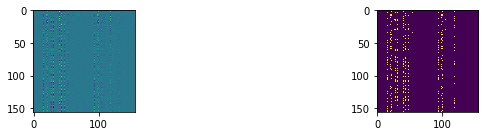

Iter: 20000
Loss: 0.004908
Composition of (156, 156) notes has been completed


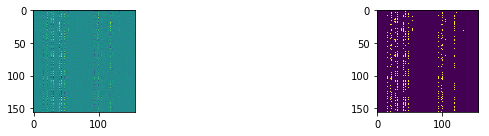

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

if not os.path.exists('out/'):
    os.makedirs('out/')

i = 0

while i <= num_epochs:
    for song in songs:
        # The songs are stored in a time x notes format. The size of each song is timesteps_in_song x 2*note_range
        # Here we reshape the songs so that each training example is a vector with num_timesteps x 2*note_range elements
        song = np.array(song)
        #song = song[:np.floor(song.shape[0]/num_timesteps).astype(int)*num_timesteps]
        #song = np.reshape(song, [song.shape[0]/num_timesteps, song.shape[1]*num_timesteps])
        # Train the RBM on batch_size examples at a time
        end_of_song = np.floor(np.shape(song)[1]/num_timesteps).astype(int)*num_timesteps
        for ind in range(1, end_of_song-1, num_timesteps/2): 
            X_train = np.expand_dims(song[ind:ind+num_timesteps], axis = 0)
            y_train = np.expand_dims(song[ind+1:ind+num_timesteps+1], axis = 0)
            _, loss_val = sess.run([training_op, loss], feed_dict={X: X_train, y: y_train})
    
            if i % 1000 == 0:
                print('Iter: {}'.format(i))
                print('Loss: {:.4}'. format(loss_val))
                next_input = np.random.randn(1,num_timesteps,n_visible)
                #next_input = np.zeros((1,num_timesteps,n_visible))
                n_steps = 5
                samples = np.zeros((1,n_visible))
                #print(np.shape(samples))
                for j in range(n_steps):
                    y_pred = sess.run(outputs, feed_dict={X: next_input})
                    next_input = y_pred
                    #print(np.shape(y_pred))
                    samples = np.append(samples,y_pred[0,:-1,:],axis = 0)

                S = samples
                print('Composition of {} notes has been completed' . format(np.shape(samples)))
                thresh_S = S>=0.5
                plt.figure(figsize=(12,2))
                plt.subplot(1,2,1)
                plt.imshow(S)
                plt.subplot(1,2,2)
                plt.imshow(thresh_S)
                plt.tight_layout()
                plt.pause(0.1)
                midi_manipulation.noteStateMatrixToMidi(thresh_S, "out/rnn_generated_chord_{}".format(i))
                #print(i)
            i += 1
